# Hyperelasticity
Author: Jørgen S. Dokken and Garth N. Wells

This section shows how to solve the hyperelasticity problem for deformation of a beam.

We start by importing `dolfinx` and some additional dependencies.
Then, we create a slender cantilever consisting of hexahedral elements and create the function space `V` for our unknown.

In [1]:
import dolfinx
import numpy as np
import ufl

from petsc4py import PETSc
from mpi4py import MPI
L = 20.0
mesh = dolfinx.BoxMesh(MPI.COMM_WORLD,[[0.0,0.0,0.0], [L, 1, 1]], [20, 5, 5], dolfinx.cpp.mesh.CellType.hexahedron)
V = dolfinx.VectorFunctionSpace(mesh, ("CG", 2))

We create two python functions for determining the facets to apply boundary conditions to

In [2]:
def left(x):
    return np.isclose(x[0], 0)

def right(x):
    return np.isclose(x[0], L)

left_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left)
right_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, right)

Next, we create a  marker based on these two functions

In [3]:
# Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full(len(left_facets), 1, dtype=np.int32), np.full(len(right_facets), 2, dtype=np.int32)])
sorted_facets = np.argsort(marked_facets)
facet_tag = dolfinx.MeshTags(mesh, mesh.topology.dim-1, marked_facets[sorted_facets], marked_values[sorted_facets])

We then create a function for supplying the boundary condition on the left side, which is fixed.

In [4]:
u_bc = dolfinx.Function(V)
with u_bc.vector.localForm() as loc:
    loc.set(0)

To apply the boundary condition, we identity the dofs located on the facets marked by the `MeshTag`.

In [5]:
left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.indices[facet_tag.values==1])
bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]

Next, we define the body force on the reference configuration (`B`), and nominal (first Piola-Kirchhoff) traction (`T`). 

In [6]:
B = dolfinx.Constant(mesh, (0, 0, 0))
T = dolfinx.Constant(mesh, (0, 0, 0))

Define the test and solution functions on the space $V$

In [7]:
v = ufl.TestFunction(V)
u = dolfinx.Function(V)

Define kinematic quantities used in the problem

In [8]:
# Spatial dimension
d = len(u)

# Identity tensor
I = ufl.variable(ufl.Identity(d))

# Deformation gradient
F = ufl.variable(I + ufl.grad(u))

# Right Cauchy-Green tensor
C = ufl.variable(F.T * F)

# Invariants of deformation tensors
Ic = ufl.variable(ufl.tr(C))
J  = ufl.variable(ufl.det(F))

Define the elasticity model via a stored strain energy density function $\psi$, and create the expression for the first Piola-Kirchhoff stress:

In [9]:
# Elasticity parameters
E, nu = 1.0e4, 0.3
mu = dolfinx.Constant(mesh, E/(2*(1 + nu)))
lmbda = dolfinx.Constant(mesh, E*nu/((1 + nu)*(1 - 2*nu)))
# Stored strain energy density (compressible neo-Hookean model)
psi = (mu / 2) * (Ic - 3) - mu * ufl.ln(J) + (lmbda / 2) * (ufl.ln(J))**2
# Stress
# Hyper-elasticity
P = ufl.diff(psi, F)

```{admonition} Comparison to linear elasticity
To illustrate the difference between linear and hyperelasticity, the following lines can be uncommented to solve the linear elasticity problem.
```

In [10]:
# P = 2.0 * mu * ufl.sym(ufl.grad(u)) + lmbda * ufl.tr(ufl.sym(ufl.grad(u))) * I

Define the variational form with traction integral over all facets with value 2. We set the quadrature degree for the integrals to 4.

In [11]:
metadata = {"quadrature_degree": 4}
ds = ufl.Measure('ds', subdomain_data=facet_tag, metadata=metadata)
dx = ufl.Measure("dx", metadata=metadata)
# Define form F (we want to find u such that F(u) = 0)
F = ufl.inner(ufl.grad(v), P)*dx - ufl.inner(v, B)*dx - ufl.inner(v, T)*ds(2) 

The next step is to solve the non-linear problem. To do so, we use Newtons method. We start by creating a class containing the core functions that we require to solve the problem.

In [12]:
from typing import List
class NonlinearPDEProblem:
    """Nonlinear problem class for solving the non-linear problem
    F(u, v) = 0 for all v in V
    """
    def __init__(self, F: ufl.form.Form, u: dolfinx.Function, bcs: List[dolfinx.DirichletBC]):
        """
        Input:
        - F: The PDE residual F(u, v)
        - u: The unknown
        - bcs: List of Dirichlet boundary conditions
        This class set up structures for solving the non-linear problem using Newton's method, 
        dF/du(u) du = -F(u)
        """
        V = u.function_space
        du = ufl.TrialFunction(V)
        self.L = F
        # Create the Jacobian matrix, dF/du
        self.a = ufl.derivative(F, u, du)
        self.bcs = bcs

        # Create matrix and vector to be used for assembly
        # of the non-linear problem
        self.matrix = dolfinx.fem.create_matrix(self.a)
        self.vector = dolfinx.fem.create_vector(self.L)

    def form(self, x: PETSc.Vec):
        """
        This function is called before the residual or Jacobian is computed. This is usually used to update ghost values.
        Input: 
           x: The vector containing the latest solution
        """
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

    def F(self, x: PETSc.Vec, b: PETSc.Vec):
        """Assemble the residual F into the vector b. 
        Input:
           x: The vector containing the latest solution
           b: Vector to assemble the residual into
        """
        # Reset the residual vector
        with b.localForm() as b_local:
            b_local.set(0.0)
        dolfinx.fem.assemble_vector(b, self.L)
        # Apply boundary condition
        dolfinx.fem.apply_lifting(b, [self.a], [self.bcs], [x], -1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        dolfinx.fem.set_bc(b, self.bcs, x, -1.0)

    def J(self, x: PETSc.Vec, A: PETSc.Mat):
        """Assemble the Jacobian matrix.
        Input:
          - x: The vector containing the latest solution
          - A: The matrix to assemble the Jacobian into
        """
        A.zeroEntries()
        dolfinx.fem.assemble_matrix(A, self.a, self.bcs)
        A.assemble()

We initialize the created class

In [13]:
problem = NonlinearPDEProblem(F, u, bcs)

and then create and customize the Newton solver

In [14]:
solver = dolfinx.cpp.nls.NewtonSolver(MPI.COMM_WORLD)

# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

# Set non-linear problem for Newton solver
solver.setF(problem.F, problem.vector)
solver.setJ(problem.J, problem.matrix)
solver.set_form(problem.form)

We create a function to plot the solution at each time step.

  warnings.warn("Plotting of higher order functions is experimental.")



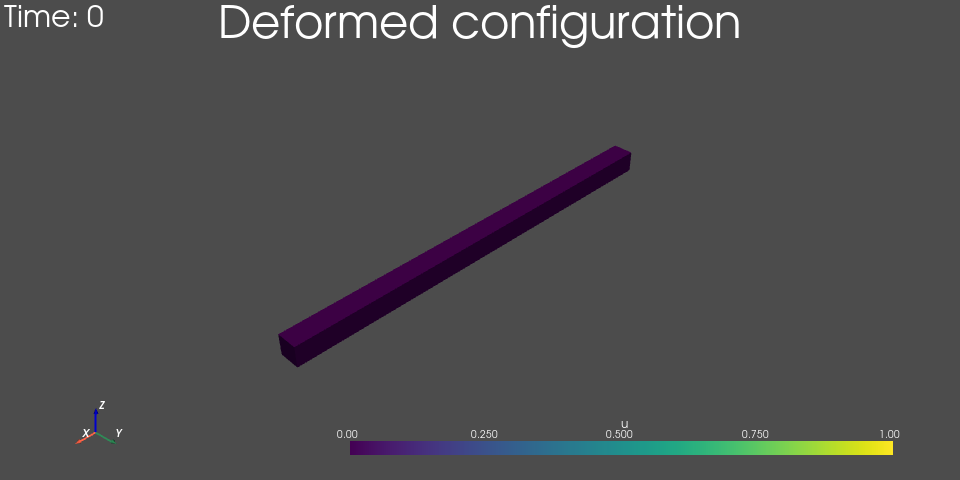

In [15]:
import pyvista
import dolfinx.plot
# Activate framebuffer, required for visualziation
pyvista.start_xvfb(wait=0.05)
# Create background plotter and mesh to attach values to
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
def plot_function(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter(window_size=[960,480])
    # Add time-stamp
    p.add_text(f"Time: {t}", font_size=12, name="timelabel")
    p.add_text("Deformed configuration", name="title", position="upper_edge")
   
    # Update point values on pyvista grid

    topology, cell_types = dolfinx.plot.create_vtk_topology(V)
    # To make this function work in parallel, we only consider ghosts owned by the current process
    num_dofs_local = V.dofmap.index_map.size_local
    # We create a geometry for our modified mesh using the dof coordinates
    geometry = V.tabulate_dof_coordinates()[:num_dofs_local]
    # As we are dealing with a vector field, we reshape the underlying dof array to accommedate for the three dimensional space
    values = np.zeros((V.dofmap.index_map.size_local, 3), dtype=np.float64)
    values[:, :mesh.geometry.dim] = uh.vector.array.real.reshape(V.dofmap.index_map.size_local, V.dofmap.index_map_bs)

    # Create grid defined by the function space for visualization
    function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    function_grid["u"] = values
    function_grid.set_active_vectors("u")
    # Warp mesh by deformation
    warped = function_grid.warp_by_vector("u", factor=1)
    
    # Add mesh to plotter and visualize
    actor = p.add_mesh(warped)
    p.show_axes()
    if not pyvista.OFF_SCREEN:
       p.show()
    # Uncomment to save png
    # figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
    # Clear plotter for next plot

plot_function(0, u)

Finally, we solve the problem over several time steps, updating the y-component of the traction

  warnings.warn("Plotting of higher order functions is experimental.")



Time step 1, Number of iterations 8, Load [ 0.   0.  -1.5]


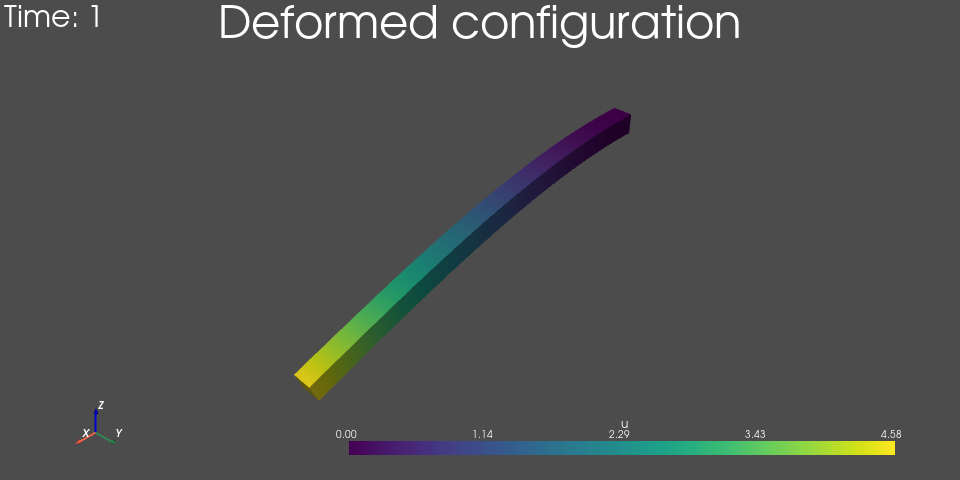

In [ ]:
dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
tval0 = -1.5
for n in range(1, 10):
    T.value[2] = n * tval0
    num_its, converged = solver.solve(u.vector)
    assert(converged)
    u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    print(f"Time step {n}, Number of iterations {num_its}, Load {T.value}")
    plot_function(n, u)